In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# -------------------------
# Helper functions
# -------------------------
def read_station_parquet(station_id: str):
    """
    Read NOAA GHCN parquet data for a given station_id and ensure DATE is datetime
    """
    path = f"s3://noaa-ghcn-pds/parquet/by_station/STATION={station_id}/"
    df = pd.read_parquet(path, storage_options={"anon": True})
    # In some files DATE is already datetime64, in others it's integer YYYYMMDD
    if not np.issubdtype(df["DATE"].dtype, np.datetime64):
        df["DATE"] = pd.to_datetime(df["DATE"].astype(str), format="%Y%m%d")
    else:
        df["DATE"] = pd.to_datetime(df["DATE"])
    return df

def make_wide(df: pd.DataFrame):
    """
    Pivot long-format (ELEMENT, DATA_VALUE) into wide format with one row per day,
    columns as ELEMENT values.
    Convert TMIN/TMAX from 0.1°C units to °C.
    """
    df_wide = df.pivot(index="DATE", columns="ELEMENT", values="DATA_VALUE")
    # convert units if columns exist
    if "TMAX" in df_wide.columns:
        df_wide["TMAX"] = df_wide["TMAX"] / 10.0
    if "TMIN" in df_wide.columns:
        df_wide["TMIN"] = df_wide["TMIN"] / 10.0
    return df_wide

In [3]:
# -------------------------
# Main function: compute climate statistics
# -------------------------

def get_station_climate(station_id: str):
    """
    Return a DataFrame containing:
    ['record_min_temp', 'average_min_temp', 'average_max_temp', 'record_max_temp']
    record = full-period extremes; average = overall mean for 1991-01-01 to 2020-12-31 
             (arithmetic mean of TMAX/TMIN, not daily climatology).
    """
    df = read_station_parquet(station_id)
    df_wide = make_wide(df)

    # Ensure both TMIN and TMAX are available
    if "TMIN" not in df_wide.columns or "TMAX" not in df_wide.columns:
        raise ValueError(f"Station {station_id} does not contain both TMIN and TMAX in GHCN parquet data.")

    # Full-period extremes (skip NaN)
    record_min = float(df_wide["TMIN"].min(skipna=True))
    record_max = float(df_wide["TMAX"].max(skipna=True))

    # 1991–2020 mean (overall mean, not daily climatology)
    clim = df_wide.loc["1991-01-01":"2020-12-31"]
    average_min = float(clim["TMIN"].mean(skipna=True))
    average_max = float(clim["TMAX"].mean(skipna=True))

    out = pd.DataFrame([{
        "record_min_temp": record_min,
        "average_min_temp": average_min,
        "average_max_temp": average_max,
        "record_max_temp": record_max
    }])
    return out

In [4]:

# -------------------------
# Plotting function: show record/avg/actual with daily climatology envelope
# -------------------------
def plot_station(station_id: str, year: int, show_legend: bool = True):
    """
    Plot daily Tmax/Tmin for a given year and station_id, overlaid with:
      - Daily historical record extremes (record envelope)
      - Daily 1991–2020 mean climatology (climatology envelope)
      - Actual Tmax/Tmin for that year
    Typical “weather vs. climate envelope” visualization.
    """
    # Read and pivot to wide format
    df = read_station_parquet(station_id)
    df_wide = make_wide(df)

    if "TMIN" not in df_wide.columns or "TMAX" not in df_wide.columns:
        raise ValueError(f"Station {station_id} does not contain both TMIN and TMAX in GHCN parquet data.")

    # 1) Compute daily climatology (by month-day) for 1991–2020
    clim = df_wide.loc["1991-01-01":"2020-12-31"]
    # group by (month, day) -> MultiIndex
    avg_max_daily = clim.groupby([clim.index.month, clim.index.day])["TMAX"].mean()
    avg_min_daily = clim.groupby([clim.index.month, clim.index.day])["TMIN"].mean()

    # Daily record values (all available years) by calendar day
    rec_max_daily = df_wide.groupby([df_wide.index.month, df_wide.index.day])["TMAX"].max()
    rec_min_daily = df_wide.groupby([df_wide.index.month, df_wide.index.day])["TMIN"].min()

    # 2) Map climatology and records onto the target year’s date list
    dates = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31", freq="D")
    md_index = [(d.month, d.day) for d in dates]

    def lookup_series(series, md_index):
        """Lookup values from (month, day)-indexed series. 
        Handle leap year Feb 29 by substituting Feb 28."""
        vals = []
        for m,d in md_index:
            key = (m,d)
            if key in series.index:
                vals.append(series.loc[key])
            elif key == (2,29):  # leap year handling
                if (2,28) in series.index:
                    vals.append(series.loc[(2,28)])
                else:
                    vals.append(np.nan)
            else:
                vals.append(np.nan)
        return np.array(vals, dtype=float)

    clim_max = lookup_series(avg_max_daily, md_index)
    clim_min = lookup_series(avg_min_daily, md_index)
    rec_max = lookup_series(rec_max_daily, md_index)
    rec_min = lookup_series(rec_min_daily, md_index)

    # 3) Extract actual daily values for the target year (missing → NaN)
    df_year = df_wide.reindex(dates)  # reindex aligns with date index
    actual_tmax = df_year["TMAX"].values
    actual_tmin = df_year["TMIN"].values

    # 4) Plot envelopes + actual values
    plt.figure(figsize=(14,6))

    # record envelope (gray)
    plt.fill_between(dates, rec_min, rec_max, color="lightgray", label="Record range (all years)")

    # climatology envelope 1991–2020 (light blue)
    plt.fill_between(dates, clim_min, clim_max, color="lightblue", label="1991-2020 mean range")

    # actual lines
    plt.plot(dates, actual_tmax, color="red", lw=1.2, label=f"{year} Tmax")
    plt.plot(dates, actual_tmin, color="blue", lw=1.2, label=f"{year} Tmin")

    # Annotate: horizontal lines for overall record/avg
    stats = get_station_climate(station_id)
    plt.axhline(stats["record_max_temp"].iloc[0], color="darkred", ls="--", lw=1, label="Overall record max")
    plt.axhline(stats["record_min_temp"].iloc[0], color="darkblue", ls="--", lw=1, label="Overall record min")
    plt.axhline(stats["average_max_temp"].iloc[0], color="orange", ls=":", lw=1, label="1991-2020 mean Tmax")
    plt.axhline(stats["average_min_temp"].iloc[0], color="skyblue", ls=":", lw=1, label="1991-2020 mean Tmin")

    plt.title(f"GHCN Station {station_id} — Daily Tmax/Tmin in {year}")
    plt.ylabel("Temperature (°C)")
    plt.xlabel("Date")
    if show_legend:
        plt.legend(loc="upper left", fontsize="small", ncol=2)
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()




Station climate stats (record / 1991-2020 means):
   record_min_temp  average_min_temp  average_max_temp  record_max_temp
0            -31.7          5.874803         16.823752             42.8


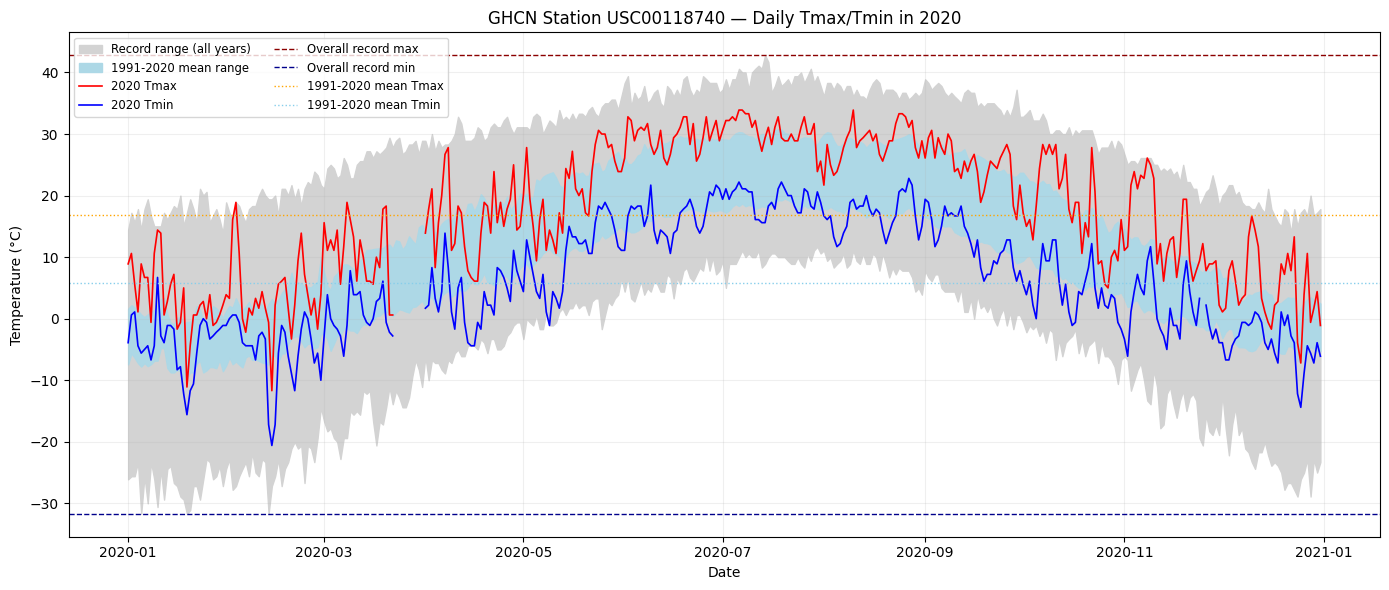

In [5]:
# -------------------------
# Example usage
# -------------------------
if __name__ == "__main__":
    # Example station (Champaign, IL)
    station_id = "USC00118740"
    # Print climate statistics
    print("Station climate stats (record / 1991-2020 means):")
    print(get_station_climate(station_id))

    # Plot for a sample year (e.g., 2020)
    plot_station(station_id, 2020)